# Evaluation

In [1]:
# Imports 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, PrecisionRecallDisplay
import os
import sys

sys.path.append(os.path.abspath("../scripts"))
from data_loader import DataLoader

import joblib
import pandas as pd
import numpy as np

In [2]:
# Load data
data_loader = DataLoader()
X_train, y_train  = data_loader.training_data
X_val, y_val = data_loader.validation_data
X_test, y_test = data_loader.test_data

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (177576, 21)
y_train shape: (177576,)
X_val shape: (25875, 21)
y_val shape: (25875,)
X_test shape: (50229, 21)
y_test shape: (50229,)


In [3]:
# logistic regression
lr_model_filename = (
    "../models/logistic_regression/lg_model_cv_sampling_pca20241129_165533.pkl"
)
logistic_regression = joblib.load(lr_model_filename)

# naive bayes
naive_bayes_filename = (
    "../models/naive_bayes/nb_model_cv_f1_20241129_111525.pkl"
)
naive_bayes = joblib.load(naive_bayes_filename)

# support vector machine
svm_model_filename = "../models/support_vector_machine/svm_model_best-f1_20241129_100911.pkl"
svm = joblib.load(svm_model_filename)

# decision tree
dc_filename = "../models/decision_trees_ensembles/dt_best_model_cv_sampling_pca20241129_184533.pkl"
dc = joblib.load(dc_filename)

rf_filename = "../models/decision_trees_ensembles/brf_best_model_cv_sampling_pca20241129_232921.pkl"
rf = joblib.load(rf_filename)

adab_filename = "../models/decision_trees_ensembles/adab_best_model_cv_sampling_pca20241130_184757.pkl"
adab = joblib.load(adab_filename)

# knn
knn_filename = "../models/knn/k=100_best_f1_postiv_20241128_204259.pkl"
knn = joblib.load(knn_filename)

# Nearest Centroid
nc_filename = "../models/nearest_centroid/best_20241127_201059.pkl"
nc = joblib.load(nc_filename)

# baselines
bl_model_filename = "../models/baseline/baseline_model_majority_20241129_225242.pkl"
bl_majority = joblib.load(bl_model_filename)

bl_model_strat_filename = "../models/baseline/baseline_model_stratified_20241129_225334.pkl"
bl_stratified = joblib.load(bl_model_strat_filename)

sys.path.append(os.path.abspath("../models/baseline/"))
from baselines import PCANNModel
baseline_pca_nn = PCANNModel(n_components=1, n_neighbors=5)

bl_model_pca_nn_filename = "../models/baseline/baseline_model_pca_nn_20241129_234922.pkl"
bl_pca_nn = joblib.load(bl_model_pca_nn_filename)

# baseline_one_feature = OneFeatureModel(
#     feature=most_correlated_feature,
#     threshold=indices_largest_gap[1]
# )
# bl_model_one_feature_filename = "../models/baseline/baseline_model_one_feature_20241129_230329.pkl"
# bl_one_feature = joblib.load(bl_model_one_feature_filename)


# Neural Network
# import torch
# from neural_network.model import NeuralNet

# nn_filename = "../models/neural_net/neural_net_20241130_195408.pkl"
# # Define the input size (must match the saved model)
# input_size = 21  # Number of features

# # Instantiate the model and load state dict
# nn = NeuralNet(input_size)
# nn.load_state_dict(torch.load(nn_filename))
# nn.eval() 


# all models
model_dict = {
    "Baseline Majority": bl_majority,
    "Baseline Stratified": bl_stratified,
    "Baseline PCA": bl_pca_nn,
    # "Baseline One Feature": bl_one_feature,
    "Logistic Regression": logistic_regression,
    "Decision Tree": dc,
    "Random Forest": rf,
    "AdaBoost Decision Trees": adab,
    "Support Vector Machine": svm,
    "K-Nearest Neighbors": knn,
    "Nearest Centroid": nc,
    "Naive Bayes": naive_bayes,
    # "Neural Network": nn
    # Add other models here
}

/Users/I549663/Library/CloudStorage/OneDrive-Personal/Dokumente/Studium/MMDS/Kurse/IE500_DataMining/Project/ie500_data_mining_project/venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/I549663/Library/CloudStorage/OneDrive-Personal/Dokumente/Studium/MMDS/Kurse/IE500_DataMining/Project/ie500_data_mining_project/venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintain

In [4]:
for model_name, model in model_dict.items():
    print(f"\n=== Hyperparameters for {model_name} ===\n")
    if hasattr(model, 'get_params'):
        print(model.get_params())
    else:
        print("This model does not have hyperparameters accessible via get_params()")


=== Hyperparameters for Baseline Majority ===

{'constant': None, 'random_state': None, 'strategy': 'most_frequent'}

=== Hyperparameters for Baseline Stratified ===

{'constant': None, 'random_state': None, 'strategy': 'stratified'}

=== Hyperparameters for Baseline PCA ===

This model does not have hyperparameters accessible via get_params()

=== Hyperparameters for Logistic Regression ===

{'memory': None, 'steps': [('resampler', RandomOverSampler(random_state=42)), ('pca', None), ('classifier', LogisticRegression(C=0.1, max_iter=10000, random_state=42, solver='newton-cg',
                   tol=0.001))], 'verbose': False, 'resampler': RandomOverSampler(random_state=42), 'pca': None, 'classifier': LogisticRegression(C=0.1, max_iter=10000, random_state=42, solver='newton-cg',
                   tol=0.001), 'resampler__random_state': 42, 'resampler__sampling_strategy': 'auto', 'resampler__shrinkage': None, 'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__dual': Fa

## Metrics

In [5]:
# Evaluate the model's performance on the test set
for model_name, model in model_dict.items():
    y_test = y_test
    X_test = X_test
    y_test_pred = model.predict(X_test)

    report = classification_report(y_test, y_test_pred, digits=4, zero_division=0)
    print(f"\n=== Model: {model_name} ===\n")
    print("Classification Report:\n", report)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy: {accuracy:.4f}")
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    specificity = tn / (tn + fp) # this is basically just the recall of the negative class
    print(f"Specificity: {specificity:.4f}") 
    cm = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix:\n", cm)


=== Model: Baseline Majority ===

Classification Report:
               precision    recall  f1-score   support

         0.0     0.8424    1.0000    0.9145     42314
         1.0     0.0000    0.0000    0.0000      7915

    accuracy                         0.8424     50229
   macro avg     0.4212    0.5000    0.4572     50229
weighted avg     0.7097    0.8424    0.7704     50229

Accuracy: 0.8424
Specificity: 1.0000

Confusion Matrix:
 [[42314     0]
 [ 7915     0]]

=== Model: Baseline Stratified ===

Classification Report:
               precision    recall  f1-score   support

         0.0     0.8425    0.8437    0.8431     42314
         1.0     0.1582    0.1570    0.1576      7915

    accuracy                         0.7355     50229
   macro avg     0.5004    0.5004    0.5004     50229
weighted avg     0.7347    0.7355    0.7351     50229

Accuracy: 0.7355
Specificity: 0.8437

Confusion Matrix:
 [[35701  6613]
 [ 6672  1243]]

=== Model: Baseline PCA ===

Classification Repor

In [6]:
import torch
from neural_network.model import NeuralNet

# Define the input size (must match the saved model)
input_size = 21  # Number of features

# Instantiate the model and load state dict
nn_model = NeuralNet(input_size)
model_save_path = "../models/neural_net/neural_net_20241130_195408.pkl"
nn_model.load_state_dict(torch.load(model_save_path))
nn_model.eval()  # Set to evaluation mode

# Example usage
X_test_tensor, _ = data_loader.test_data
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

with torch.no_grad():
    predictions = (nn_model((X_test_tensor).squeeze()) > 0.5).long()
    # print("Predictions:", predictions)


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
report = classification_report(y_test, predictions, digits=4, zero_division=0)
print(report)

/var/folders/mx/80hdp5rj4v550swmwk6ryqmc0000gn/T/ipykernel_35099/2961893547.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(model_sa

              precision    recall  f1-score   support

         0.0     0.9191    0.8068    0.8593     42314
         1.0     0.3753    0.6205    0.4677      7915

    accuracy                         0.7775     50229
   macro avg     0.6472    0.7137    0.6635     50229
weighted avg     0.8334    0.7775    0.7976     50229



In [7]:
metrics_df = pd.DataFrame(columns=[
    'Model', 
    'Accuracy', 
    'Overall_Precision', 
    'Overall_Recall', 
    'Overall_F1',
    'Precision_Negative',
    'Precision_Positive',
    'Specificity',
    'Recall_Negative', 
    'Recall_Positive', 
    'F1-Score_Negative', 
    'F1-Score_Positive', 
])

metrics_list = []  # Temporary list to store rows before creating the final DataFrame

for model_name, model in model_dict.items():
    y_test_pred = model.predict(X_test)
    report = classification_report(y_test, y_test_pred, digits=4, output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_test, y_test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    specificity = tn / (tn + fp)  # Specificity calculation
    
    # Metrics for the negative class ('0.0')
    precision_negative = report['0.0']['precision']
    recall_negative = report['0.0']['recall']
    f1_score_negative = report['0.0']['f1-score']
    
    # Metrics for the positive class ('1.0')
    precision_positive = report['1.0']['precision']
    recall_positive = report['1.0']['recall']
    f1_score_positive = report['1.0']['f1-score']
    
    # Overall metrics (from 'weighted avg')
    overall_precision = report['weighted avg']['precision']
    overall_recall = report['weighted avg']['recall']
    overall_f1 = report['weighted avg']['f1-score']
    
    # Append metrics as a dictionary to the list
    metrics_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Overall_Precision': overall_precision,
        'Overall_Recall': overall_recall,
        'Overall_F1': overall_f1,
        'Precision_Negative': precision_negative,
        'Precision_Positive': precision_positive,
        'Specificity': specificity,
        'Recall_Negative': recall_negative,
        'Recall_Positive': recall_positive,
        'F1-Score_Negative': f1_score_negative,
        'F1-Score_Positive': f1_score_positive,

    })

# Convert the list of metrics into a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Round all numeric values to 4 decimal places
metrics_df = metrics_df.round(4)

metrics_df

,Model,Accuracy,Overall_Precision,Overall_Recall,Overall_F1,Precision_Negative,Precision_Positive,Specificity,Recall_Negative,Recall_Positive,F1-Score_Negative,F1-Score_Positive
0,Baseline Majority,0.8424,0.7097,0.8424,0.7704,0.8424,0.0000,1.0000,1.0000,0.0000,0.9145,0.0000
1,Baseline Stratified,0.7358,0.7363,0.7358,0.7360,0.8435,0.1631,0.8427,0.8427,0.1639,0.8431,0.1635
2,Baseline PCA,0.8154,0.7533,0.8154,0.7754,0.8476,0.2489,0.9521,0.9521,0.0849,0.8968,0.1266
3,Logistic Regression,0.7280,0.8480,0.7280,0.7624,0.9431,0.3395,0.7205,0.7205,0.7678,0.8170,0.4708
4,Decision Tree,0.6988,0.8439,0.6988,0.7386,0.9428,0.3153,0.6840,0.6840,0.7781,0.7928,0.4488
5,Random Forest,0.7535,0.8434,0.7535,0.7818,0.9341,0.3583,0.7611,0.7611,0.7131,0.8388,0.4770
6,AdaBoost Decision Trees,0.7467,0.8417,0.7467,0.7763,0.9335,0.3507,0.7530,0.7530,0.7132,0.8336,0.4702
7,Support Vector Machine,0.4792,0.7714,0.4792,0.5415,0.8809,0.1857,0.4415,0.4415,0.6809,0.5882,0.2918
8,K-Nearest Neighbors,0.7433,0.8380,0.7433,0.7732,0.9303,0.3448,0.7516,0.7516,0.6988,0.8314,0.4617
9,Nearest Centroid,0.6902,0.8374,0.6902,0.7312,0.9370,0.3051,0.6779,0.6779,0.7562,0.7866,0.4348


## Confusion Matrix Plot

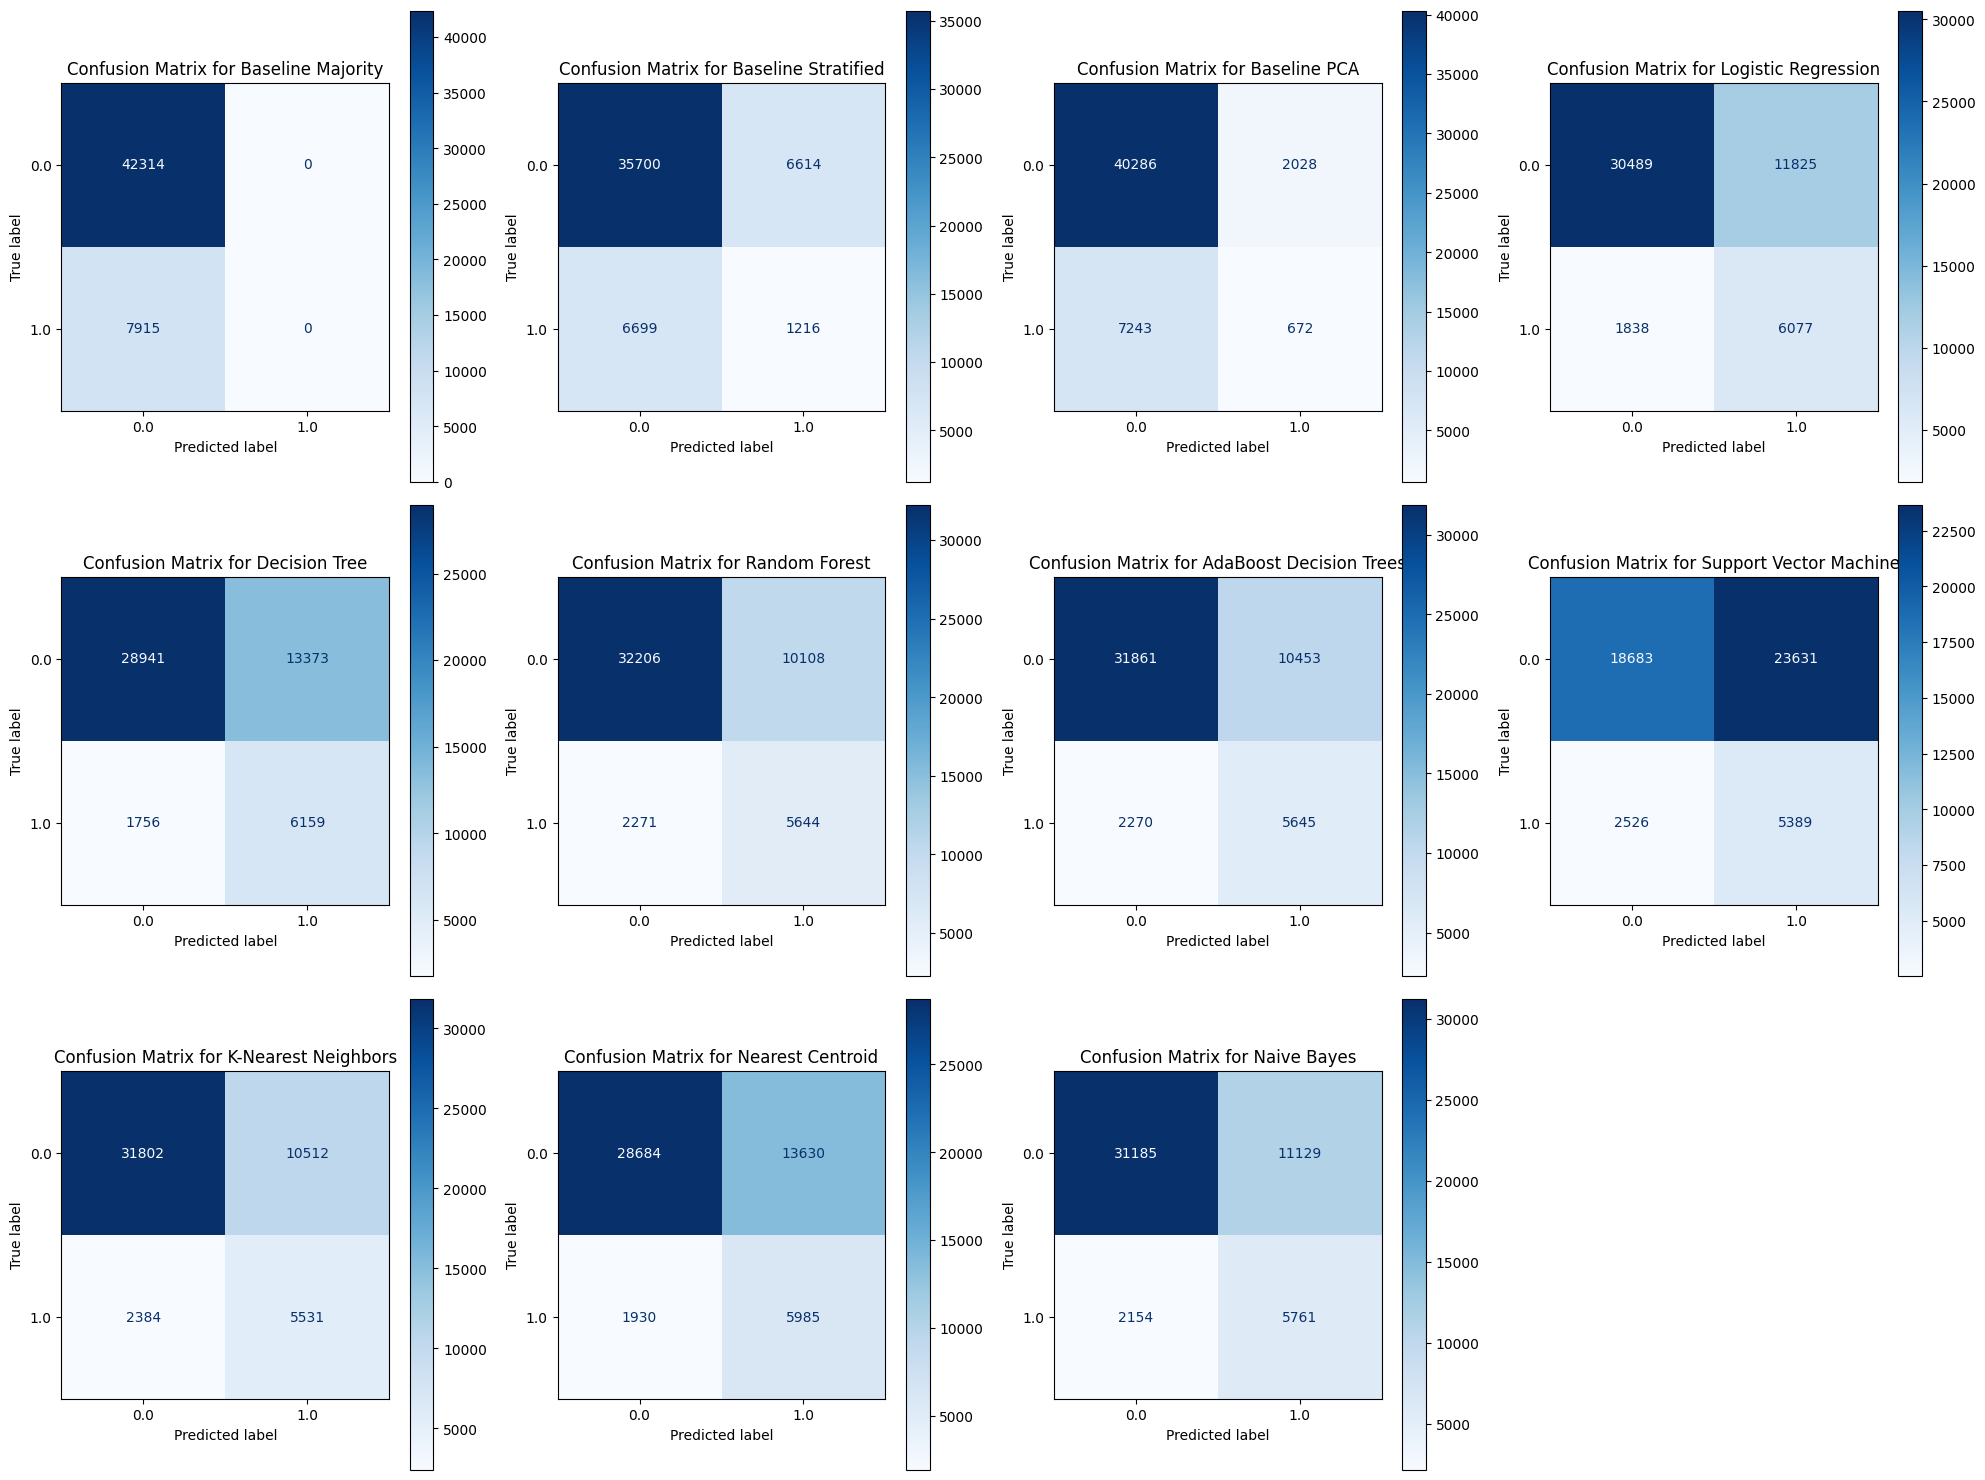

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Number of models to plot
n_models = len(model_dict)

# Determine grid size (e.g., 2x2 for 4 models, 3x2 for 6 models, etc.)
rows = int(n_models**0.5)
cols = (n_models + rows - 1) // rows  # Ceiling division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

# Flatten the axes array for easy indexing, in case it’s a multi-dimensional array
axes = axes.flatten()

for idx, (model_name, model) in enumerate(model_dict.items()):
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Plot confusion matrix on the corresponding subplot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues, values_format='d')
    axes[idx].set_title(f'Confusion Matrix for {model_name}')
    
# Hide any unused subplots
for ax in axes[len(model_dict):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


## Precision Recall Curve

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize a dictionary to store precision-recall data for all models
pr_curves = {}

# Dictionary to store average precision scores (already exists)
ap_scores = {}

# Iterate over models and store precision-recall data
for model_name, model in model_dict.items():
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        try:
            y_test_proba = model.decision_function(X_test)
        except:
            continue
    
    # Compute precision, recall, and average precision
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    avg_precision = average_precision_score(y_test, y_test_proba)
    
    # Store results
    pr_curves[model_name] = (precision, recall)
    ap_scores[model_name] = avg_precision

# Add neural network to the stored data
with torch.no_grad():
    y_test_proba_nn = nn_model(X_test_tensor).squeeze().numpy()
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_test_proba_nn)
avg_precision_nn = average_precision_score(y_test, y_test_proba_nn)
pr_curves["NeuralNet"] = (precision_nn, recall_nn)
ap_scores["NeuralNet"] = avg_precision_nn

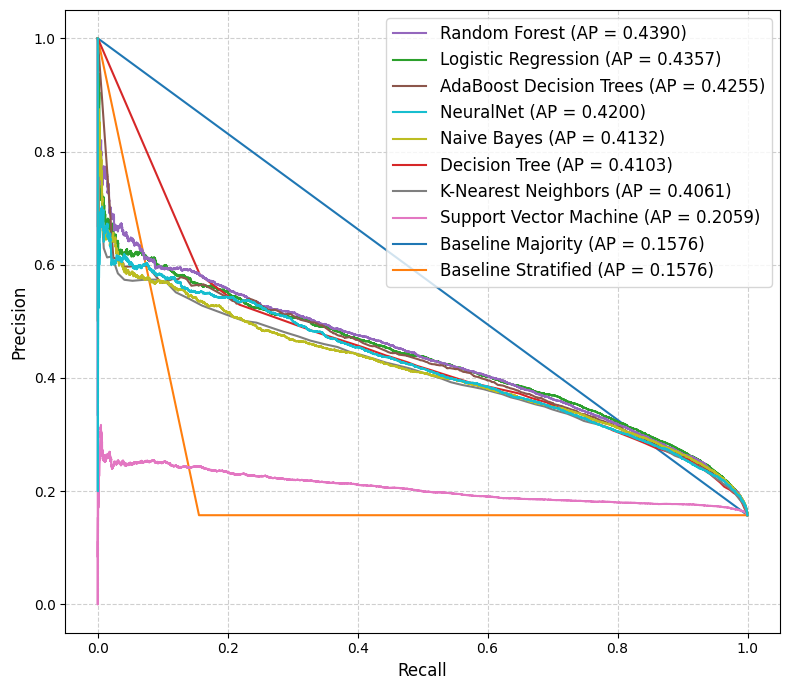

In [10]:
# Plot the Precision-Recall curves
plt.figure(figsize=(8, 7))
for model_name, (precision, recall) in pr_curves.items():
    plt.plot(recall, precision, label=f"{model_name} (AP = {ap_scores[model_name]:.4f})")

# Sort the legend labels by average precision
sorted_handles_labels = sorted(
    zip(plt.gca().get_legend_handles_labels()[0], plt.gca().get_legend_handles_labels()[1]),
    key=lambda x: float(x[1].split('= ')[1][:-1]),
    reverse=True
)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add plot customizations
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.legend(sorted_handles, sorted_labels, fontsize=12)
plt.tight_layout()
plt.show()


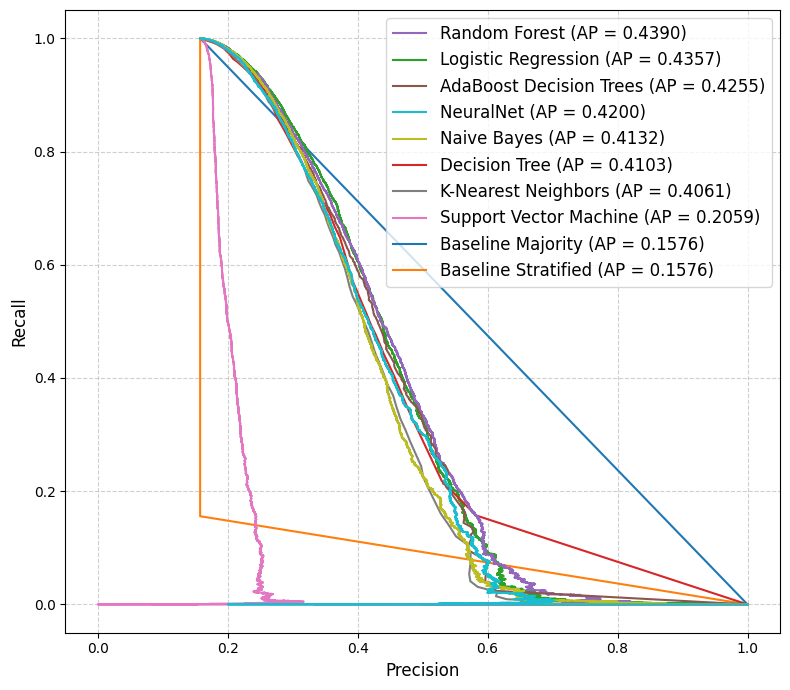

In [32]:
# Plot the Precision-Recall curves with switched axes
plt.figure(figsize=(8, 7))
for model_name, (precision, recall) in pr_curves.items():
    plt.plot(precision, recall, label=f"{model_name} (AP = {ap_scores[model_name]:.4f})")

# Sort the legend labels by average precision
sorted_handles_labels = sorted(
    zip(plt.gca().get_legend_handles_labels()[0], plt.gca().get_legend_handles_labels()[1]),
    key=lambda x: float(x[1].split('= ')[1][:-1]),
    reverse=True
)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add plot customizations
plt.xlabel('Precision', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.legend(sorted_handles, sorted_labels, fontsize=12)
plt.tight_layout()
plt.show()

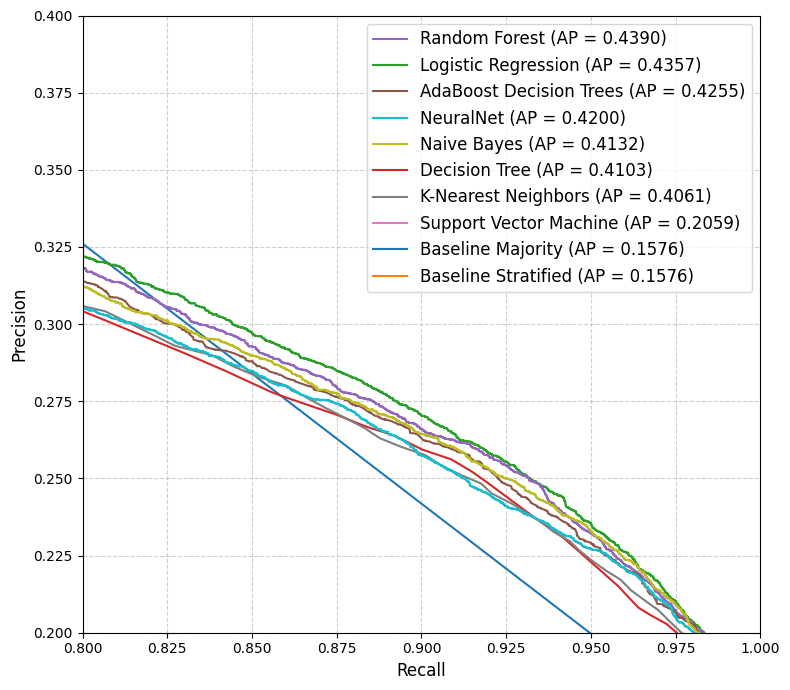

In [11]:
# Plot the Precision-Recall curves with adjusted limits
plt.figure(figsize=(8, 7))
for model_name, (precision, recall) in pr_curves.items():
    plt.plot(recall, precision, label=f"{model_name} (AP = {ap_scores[model_name]:.4f})")

# Sort the legend labels by average precision
sorted_handles_labels = sorted(
    zip(plt.gca().get_legend_handles_labels()[0], plt.gca().get_legend_handles_labels()[1]),
    key=lambda x: float(x[1].split('= ')[1][:-1]),
    reverse=True
)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add plot customizations
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.legend(sorted_handles, sorted_labels, fontsize=12)

# Apply x and y limits
plt.xlim(0.8, 1)
plt.ylim(0.2, 0.4)
plt.tight_layout()
plt.show()


## ROC Curve

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialize dictionaries for ROC data
roc_curves = {}
auc_scores = {}

# Use the stored probabilities to compute ROC curves
for model_name in pr_curves.keys():
    if model_name == "NeuralNet":
        y_test_proba = y_test_proba_nn
    else:
        # Extract probabilities for the current model
        y_test_proba = model_dict[model_name].predict_proba(X_test)[:, 1]
    
    # Compute false positive rate, true positive rate, and AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    
    # Store results
    roc_curves[model_name] = (fpr, tpr)
    auc_scores[model_name] = roc_auc

# Compute ROC metrics for Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_test_proba_nn)
roc_auc_nn = roc_auc_score(y_test, y_test_proba_nn)

# Add Neural Network to the stored ROC data
roc_curves["NeuralNet"] = (fpr_nn, tpr_nn)
auc_scores["NeuralNet"] = roc_auc_nn

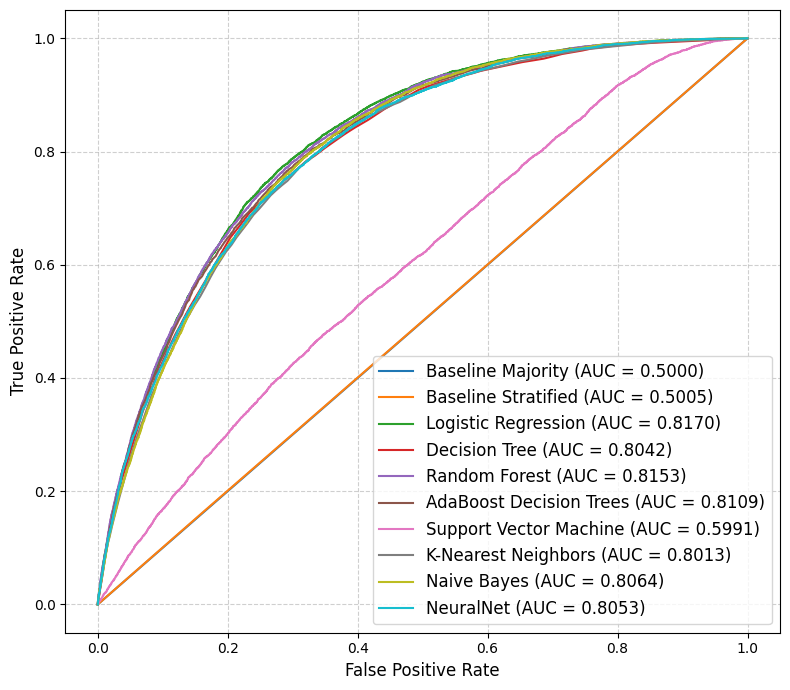

In [13]:
# Initialize a figure for the ROC curve
plt.figure(figsize=(8, 7))

# Plot the ROC curves for all models
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_scores[model_name]:.4f})")

# Add plot customizations
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.legend(fontsize=12)

# Optionally adjust x-axis limits
# plt.xlim(0, 0.4)

plt.tight_layout()

# Display the ROC plot
plt.show()

## Conclusion

In [14]:
metrics_df.T

,0,1,2,3,4,5,6,7,8,9,10
Model,Baseline Majority,Baseline Stratified,Baseline PCA,Logistic Regression,Decision Tree,Random Forest,AdaBoost Decision Trees,Support Vector Machine,K-Nearest Neighbors,Nearest Centroid,Naive Bayes
Accuracy,0.8424,0.7358,0.8154,0.728,0.6988,0.7535,0.7467,0.4792,0.7433,0.6902,0.7356
Overall_Precision,0.7097,0.7363,0.7533,0.848,0.8439,0.8434,0.8417,0.7714,0.838,0.8374,0.8417
Overall_Recall,0.8424,0.7358,0.8154,0.728,0.6988,0.7535,0.7467,0.4792,0.7433,0.6902,0.7356
Overall_F1,0.7704,0.736,0.7754,0.7624,0.7386,0.7818,0.7763,0.5415,0.7732,0.7312,0.7677
Precision_Negative,0.8424,0.8435,0.8476,0.9431,0.9428,0.9341,0.9335,0.8809,0.9303,0.937,0.9354
Precision_Positive,0.0,0.1631,0.2489,0.3395,0.3153,0.3583,0.3507,0.1857,0.3448,0.3051,0.3411
Specificity,1.0,0.8427,0.9521,0.7205,0.684,0.7611,0.753,0.4415,0.7516,0.6779,0.737
Recall_Negative,1.0,0.8427,0.9521,0.7205,0.684,0.7611,0.753,0.4415,0.7516,0.6779,0.737
Recall_Positive,0.0,0.1639,0.0849,0.7678,0.7781,0.7131,0.7132,0.6809,0.6988,0.7562,0.7279


In [23]:
metrics_df_filtered = metrics_df[[
    'Model', 
    'Accuracy', 
    'Precision_Negative', 
    'Precision_Positive', 
    'Recall_Negative', 
    'Recall_Positive', 
    'F1-Score_Negative', 
    'F1-Score_Positive'
]]

# Reorder the rows based on the specified model order
model_order = [
    "Baseline Stratified",
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "AdaBoost Decision Trees",
    "Support Vector Machine",
    "K-Nearest Neighbors",
    "Nearest Centroid",
    "Naive Bayes",
    "Baseline PCA"
    # "Neural Network"  # Uncomment if Neural Network metrics are available
]

metrics_df_filtered = metrics_df_filtered.set_index('Model').loc[model_order].reset_index()

transposed_metrics = metrics_df_filtered.T
transposed_metrics

,0,1,2,3,4,5,6,7,8,9
Model,Baseline Stratified,Logistic Regression,Decision Tree,Random Forest,AdaBoost Decision Trees,Support Vector Machine,K-Nearest Neighbors,Nearest Centroid,Naive Bayes,Baseline PCA
Accuracy,0.7358,0.728,0.6988,0.7535,0.7467,0.4792,0.7433,0.6902,0.7356,0.8154
Precision_Negative,0.8435,0.9431,0.9428,0.9341,0.9335,0.8809,0.9303,0.937,0.9354,0.8476
Precision_Positive,0.1631,0.3395,0.3153,0.3583,0.3507,0.1857,0.3448,0.3051,0.3411,0.2489
Recall_Negative,0.8427,0.7205,0.684,0.7611,0.753,0.4415,0.7516,0.6779,0.737,0.9521
Recall_Positive,0.1639,0.7678,0.7781,0.7131,0.7132,0.6809,0.6988,0.7562,0.7279,0.0849
F1-Score_Negative,0.8431,0.817,0.7928,0.8388,0.8336,0.5882,0.8314,0.7866,0.8244,0.8968
F1-Score_Positive,0.1635,0.4708,0.4488,0.477,0.4702,0.2918,0.4617,0.4348,0.4645,0.1266


In [30]:
pca_base = metrics_df_filtered[metrics_df_filtered['Model'] == 'Baseline PCA'].T
print(pca_base)

                               9
Model               Baseline PCA
Accuracy                  0.8154
Precision_Negative        0.8476
Precision_Positive        0.2489
Recall_Negative           0.9521
Recall_Positive           0.0849
F1-Score_Negative         0.8968
F1-Score_Positive         0.1266


In [17]:
# Neural Net
# Evlauaiton on test data in deep neural network notebook:

#               precision    recall  f1-score   support

#          0.0     0.9191    0.8068    0.8593     42314
#          1.0     0.3753    0.6205    0.4677      7915

#     accuracy                         0.7775     50229
#    macro avg     0.6472    0.7137    0.6635     50229
# weighted avg     0.8334    0.7775    0.7976     50229

In [ ]:
# Validation Accuracy: 0.7940483091787439
# Classification Report:
#                precision    recall  f1-score   support

#          0.0     0.8858    0.8673    0.8765     21797
#          1.0     0.3620    0.4024    0.3811      4078

#     accuracy                         0.7940     25875
#    macro avg     0.6239    0.6349    0.6288     25875
# weighted avg     0.8033    0.7940    0.7984     25875
